# Project: predicting orders for Glovo

Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.

## EDA

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?

## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?


In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import warnings
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tools.eval_measures import mse,rmse 
from sklearn.metrics import mean_absolute_percentage_error as maperror    # for ETS Plots
from pmdarima import auto_arima  

# Filter out future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Visualizations

In [5]:
data = pd.read_csv('data_BCN.csv')
fig = px.line(data, x='time', y='orders', title='Hourly Glovo Orders (Zoomed in on 2020)')

fig.update_xaxes(range=['2022-01-01', '2022-02-01']) #inital window for better visualization

fig.show()

In [6]:
data.head()

,time,orders,city
0,2021-02-01 00:00:00,0.0,BCN
1,2021-02-01 01:00:00,0.0,BCN
2,2021-02-01 02:00:00,0.0,BCN
3,2021-02-01 03:00:00,0.0,BCN
4,2021-02-01 04:00:00,0.0,BCN


In [7]:
TARGET = "orders"

In [8]:
data[[TARGET]].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
orders,8766.0,73.15,111.04,0.0,0.0,30.0,97.0,939.0


array([[<Axes: title={'center': 'orders'}>]], dtype=object)

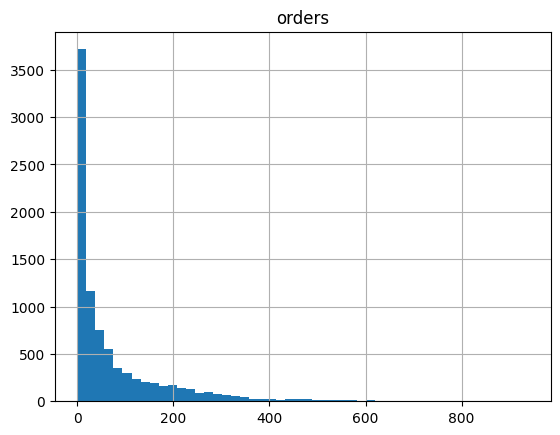

In [9]:
data[[TARGET]].hist(bins=50)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    8766 non-null   object 
 1   orders  8766 non-null   float64
 2   city    8766 non-null   object 
dtypes: float64(1), object(2)
memory usage: 205.6+ KB


In [11]:
# Set time as date value
data['time'] = pd.to_datetime(data['time'])
data['time'].value_counts().value_counts()

count
1    8766
Name: count, dtype: int64

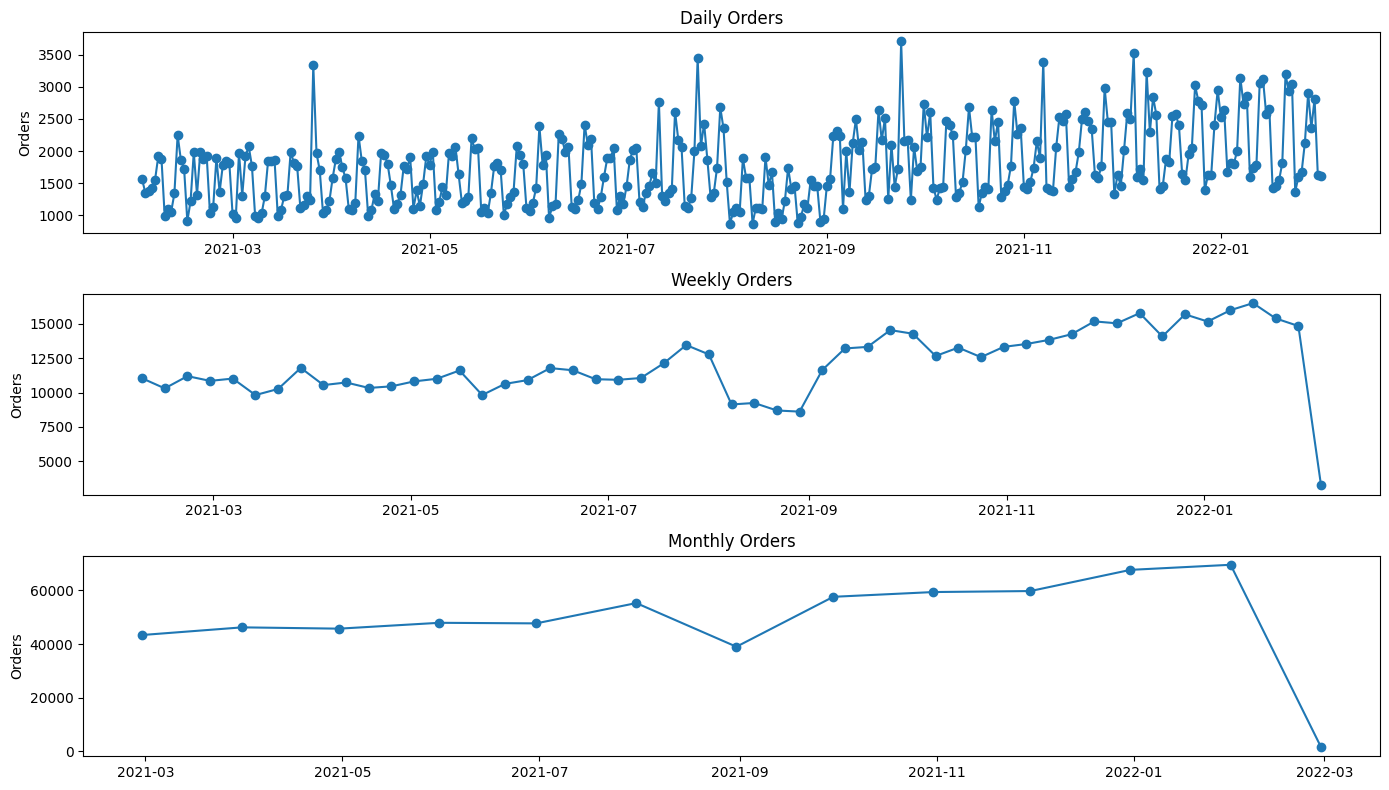

In [12]:
# Plot the orders sum daily, weekly and monthly
data['date'] = data['time']
data.set_index('date', inplace=True)

# Resample the data
daily_orders = data['orders'].resample('D').sum()
weekly_orders = data['orders'].resample('W').sum()
monthly_orders = data['orders'].resample('M').sum()

# Plot the data
plt.figure(figsize=(14, 8))

# Plot daily orders
plt.subplot(3, 1, 1)
plt.plot(daily_orders, marker='o')
plt.title('Daily Orders')
plt.ylabel('Orders')

# Plot weekly orders
plt.subplot(3, 1, 2)
plt.plot(weekly_orders, marker='o')
plt.title('Weekly Orders')
plt.ylabel('Orders')

# Plot monthly orders
plt.subplot(3, 1, 3)
plt.plot(monthly_orders, marker='o')
plt.title('Monthly Orders')
plt.ylabel('Orders')

plt.tight_layout()
plt.show()

In [13]:
# Add time features
data['quarter'] = data.index.quarter
data['year'] = data.index.year
data['month'] = data.index.month
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

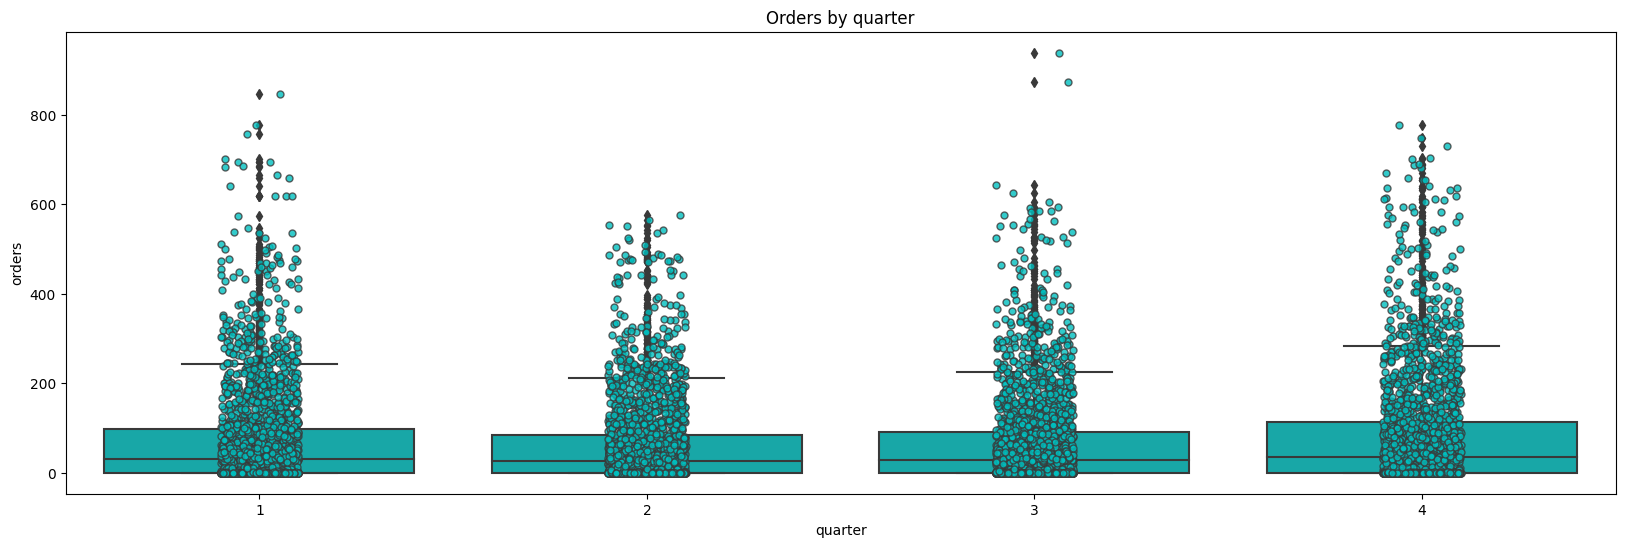

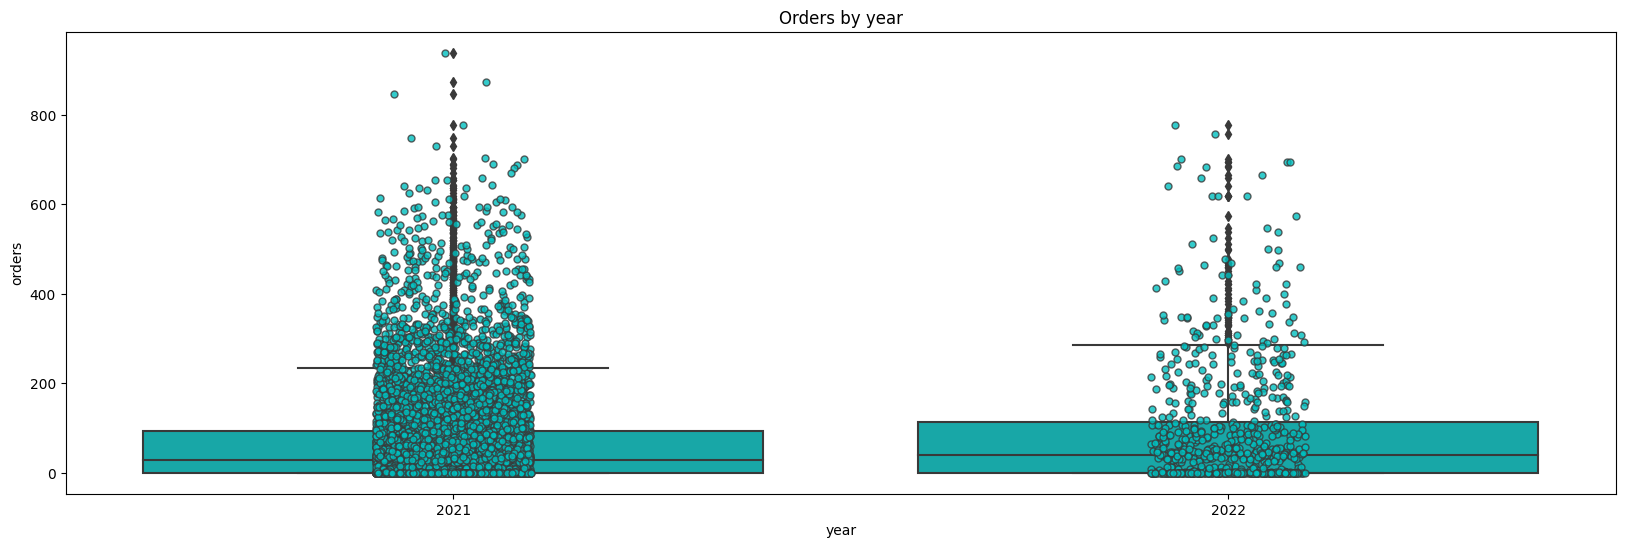

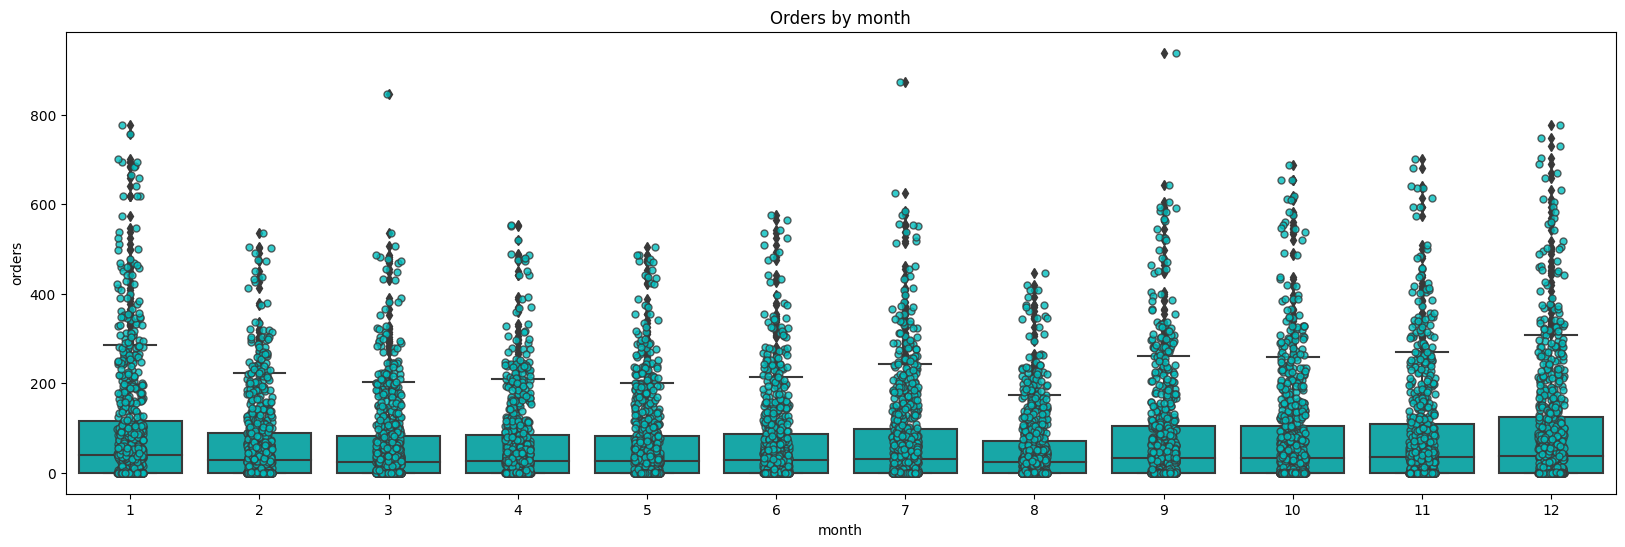

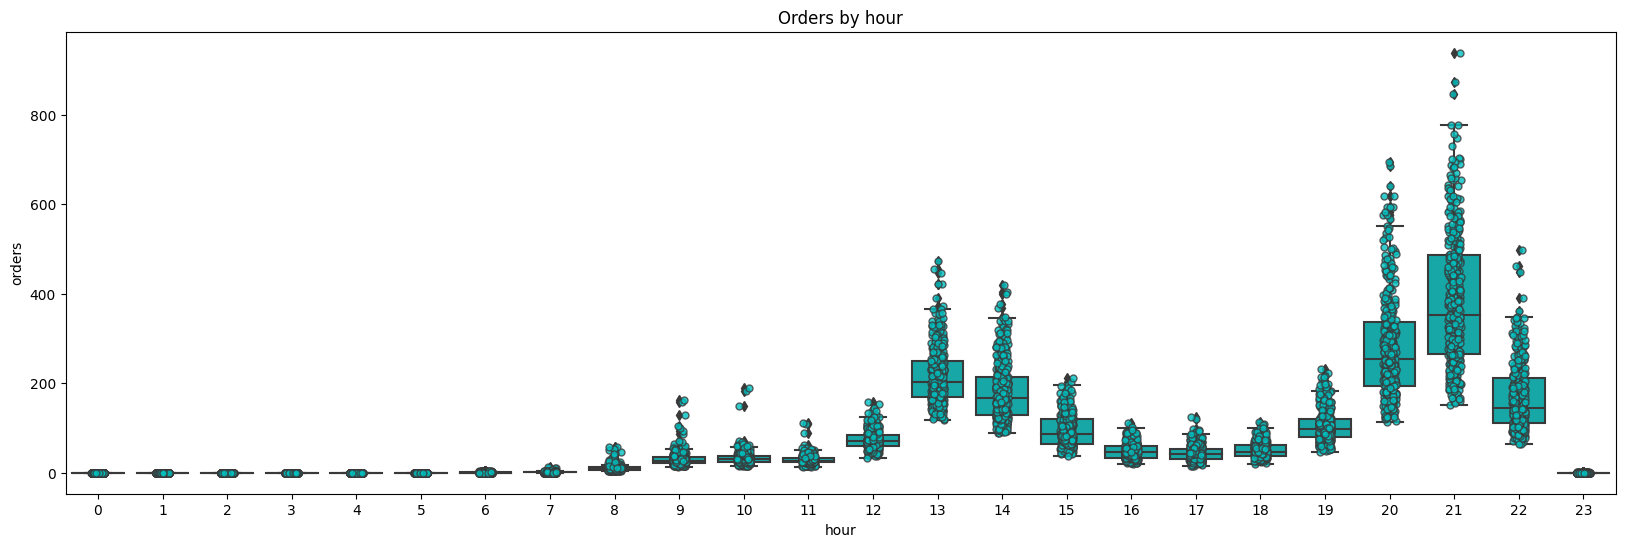

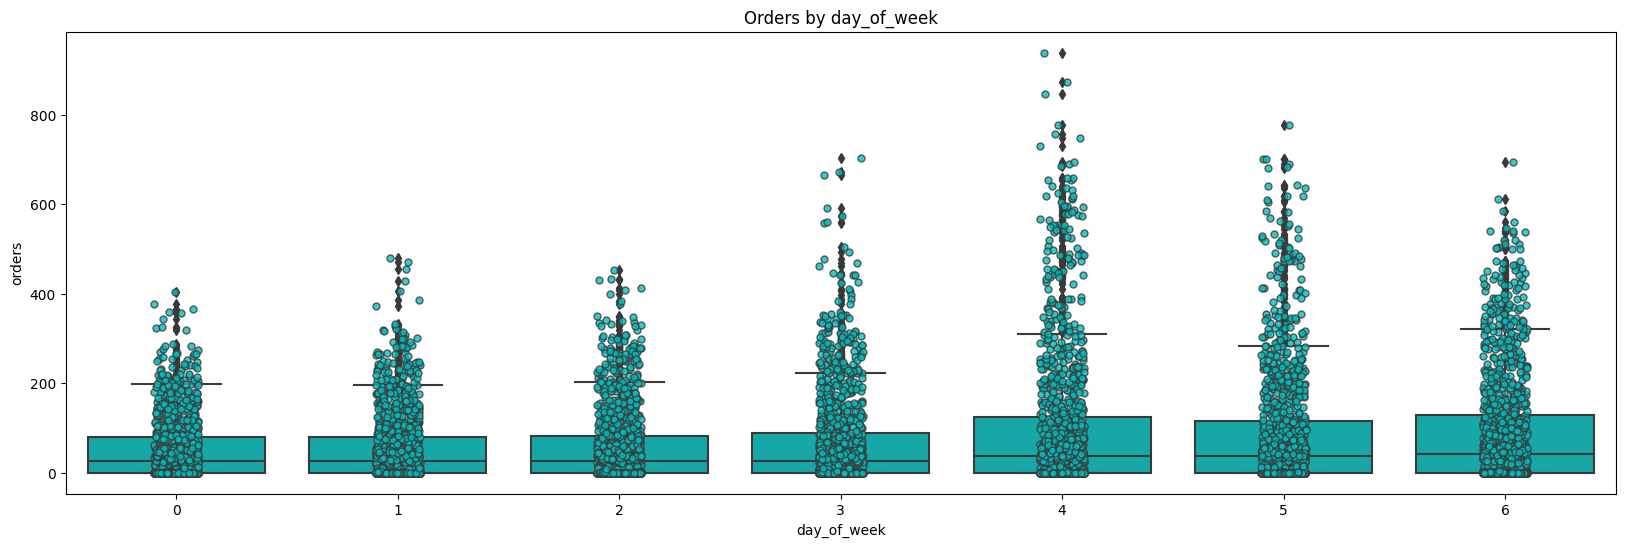

In [14]:
# Plot boxplots and stripplots for time features
time_features = [
    'quarter',
    'year',
    'month',
    'hour',
    'day_of_week'
]

for f_name in time_features:
    fig, ax = plt.subplots(figsize=(20, 6))
    sns.boxplot(x=f_name, y="orders", data=data, ax=ax, color='c')
    sns.stripplot(data=data, x=f_name, y='orders', ax=ax, linewidth=1, color='c', alpha=.8)
    ax.set_title(f'Orders by {f_name}')
    plt.show()

In [15]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['orders'])
# Output the results
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -10.412660
p-value: 0.000000


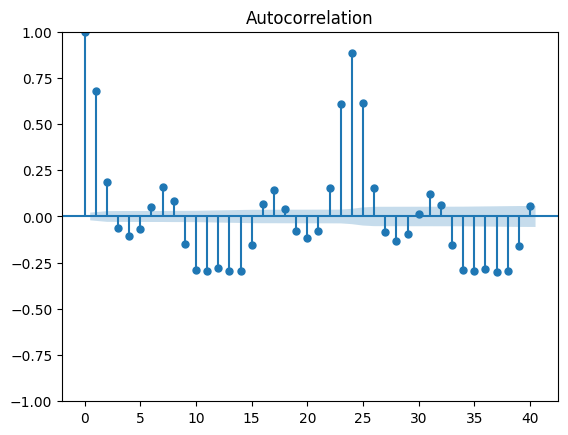

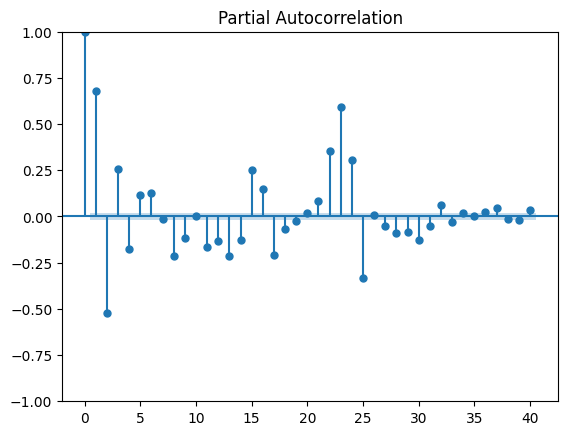

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data['orders'], lags=40)
plot_pacf(data['orders'], lags=40)
plt.show()

A p-value below 0.05 indicates stationarity, and our data meets this criterion, so we do not need to difference it.

# Model

In [17]:
# load dataset
df_input = data.copy()
df_input = df_input['20211201':'20220201']

# dataframe for SARIMAX
df_H = df_input[['orders', 'hour']]
# df_H['hour'] = df_H['hour'].astype("category")

# add weekly dummy variables 
df_H_dummies = pd.get_dummies(df_H['hour'])
df_H_dummies.drop(df_H_dummies.iloc[:,2:26], inplace=True, axis=1)
df_H = pd.merge(df_H, df_H_dummies, how='left', left_index=True, right_index=True)
df_H.drop('hour', inplace=True, axis=1)

# reduce series load to circumvent scaling issues with auto_arima 
df_H_auto = df_H['20211201':'20220201']

# run auto arima on hourly data ARIMA
auto_arima(df_H_auto['orders']).summary() 
# SARIMAX(2, 0, 0) 

# run auto arima on hourly data SARIMA
auto_arima(df_H_auto['orders'],seasonal=True,m=24).summary()
# SARIMAX(2, 0, 0)x(2, 0, 0, 24) 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1512
Model:             SARIMAX(2, 0, 1)x(0, 0, [1, 2], 24)   Log Likelihood               -8209.138
Date:                                 Sun, 26 May 2024   AIC                          16432.276
Time:                                         07:56:15   BIC                          16469.524
Sample:                                     12-01-2021   HQIC                         16446.146
                                          - 02-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     53.3373      7.975      6.688      0.000      37.706      68.969
ar.L1          0.6039      0.081      7.495      0.000       0.446       0.762
ar.L2         -0.1924      0.063     -3.035      0.002      -0.317      -0.068
ma.L1          0.3031      0.079      3.817      0.000       0.147       0.459
ma.S.L24       0.6939      0.012     56.932      0.000       0.670       0.718
ma.S.L48       0.4907      0.012     40.040      0.000       0.467       0.515
sigma2      3003.5174     55.393     54.222      0.000    2894.948    3112.086
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             15590.45
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                             2.86
Prob(H) (two-sided):                  0.27   Kurtosis:                        17.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# run ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
# use ADF function       
adf_test(df_H['orders'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -4.013891
p-value                    0.001339
# lags used               24.000000
# observations          1487.000000
critical value (1%)       -3.434755
critical value (5%)       -2.863486
critical value (10%)      -2.567806
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [19]:
# Train Test set split - we want to forecast 1 month into the future so out test set should be at least one month 
df = df_H
len(df)
# we will go with a train-test split such that our test set represents 168 Hours worth of data
train1 =  df[:len(df)-168]
test1 = df[len(df)-168:]
len(df) == len(train1) + len(test1) # True

# forecast start and end
# obtain predicted results
start1 = len(train1)
end1 = len(train1)+len(test1)-1

# vector of exogenous variable
exog_train = train1.iloc[:,1:] 
exog_forecast = test1.iloc[:,1:] 

c:\Users\jaoss\Desktop\Data_Science\mycondaenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\jaoss\Desktop\Data_Science\mycondaenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\jaoss\Desktop\Data_Science\mycondaenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\jaoss\Desktop\Data_Science\mycondaenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\jaoss\Desktop\Data_Science\mycondaenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\jaoss\

[Text(0.5, 0, ''), Text(0, 0.5, 'orders')]

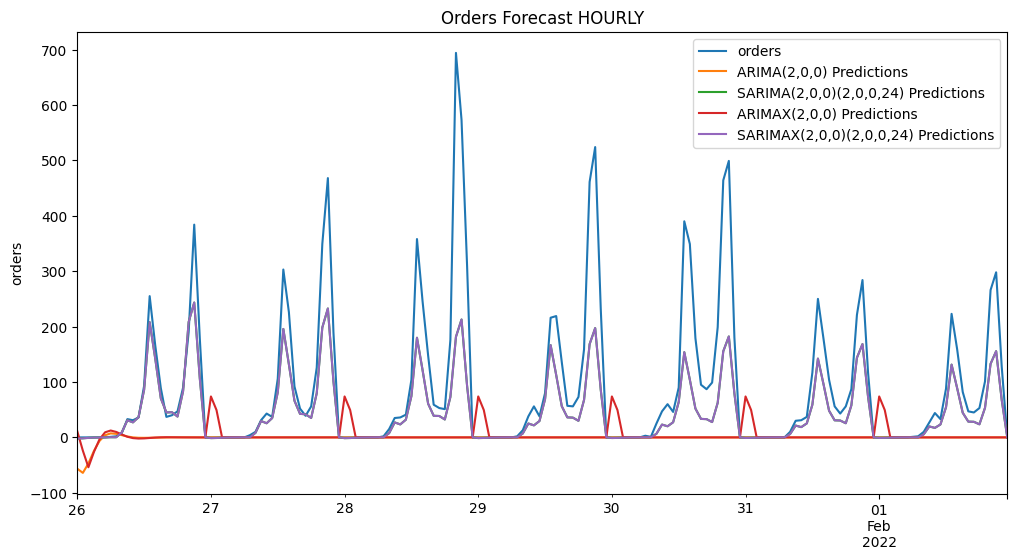

In [20]:
# Model WITHOUT Exogenous

# Fit ARIMA WITHOUT EXOGENOUS
model = SARIMAX(train1['orders'],order=(2,0,0),enforce_invertibility=False)
results = model.fit()
results.summary()

# predict
predictions = results.predict(start=start1, end=end1).rename('ARIMA(2,0,0) Predictions')
predictions.index = test1.index.copy()


# Fit SARIMA WITHOUT EXOGENOUS
model1 = SARIMAX(train1['orders'],order=(2,0,0),seasonal_order=(2,0,0,24),enforce_invertibility=False)
results1 = model1.fit()
results1.summary()

# predict
predictions1 = results1.predict(start=start1, end=end1).rename('SARIMA(2,0,0)(2,0,0,24) Predictions')
predictions1.index = test1.index.copy()

# Model WITH Exogenous

# Fit ARIMAX WITH EXOGENOUS
model2 = SARIMAX(train1['orders'],exog=exog_train,order=(2,0,0),enforce_invertibility=False)
results2 = model2.fit()
results2.summary()

# predict
predictions2 = results2.predict(start=start1, end=end1, exog=exog_forecast).rename('ARIMAX(2,0,0) Predictions')
predictions2.index = test1.index.copy()

# Fit SARIMA WITH EXOGENOUS
model3 = SARIMAX(train1['orders'],exog=exog_train,order=(2,0,0),seasonal_order=(2,0,0,24),enforce_invertibility=False)
results3 = model3.fit()
results3.summary()

# predict
predictions3 = results3.predict(start=start1, end=end1, exog=exog_forecast).rename('SARIMAX(2,0,0)(2,0,0,24) Predictions')
predictions3.index = test1.index.copy()

# plot predictions
title='Orders Forecast HOURLY'
ylabel='orders'
xlabel=''

ax = test1['orders'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions3.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

c:\Users\jaoss\Desktop\Data_Science\mycondaenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.

c:\Users\jaoss\Desktop\Data_Science\mycondaenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency h will be used.



[Text(0.5, 0, ''), Text(0, 0.5, 'orders')]

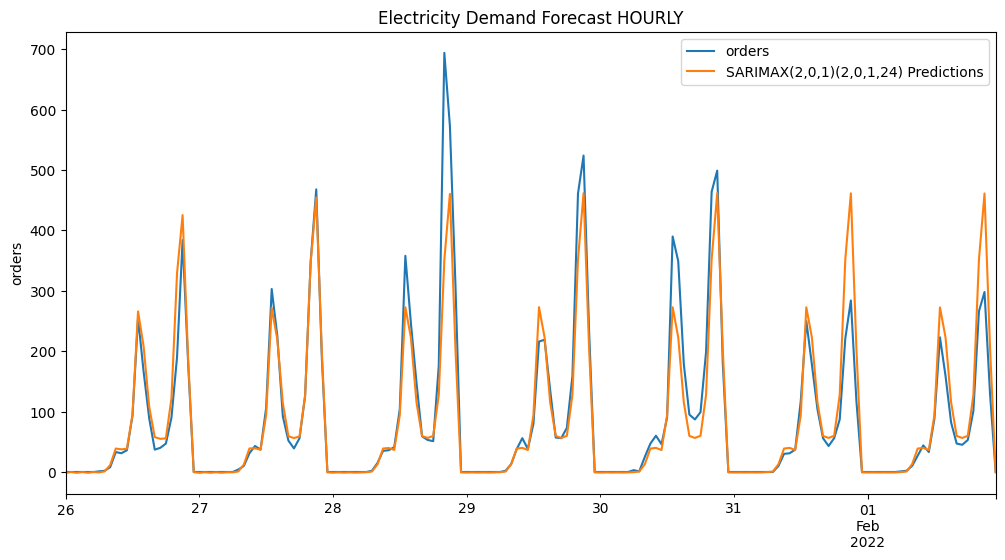

In [21]:
# Model WITHOUT Exogenous

# Fit SARIMA WITH EXOGENOUS
model3 = SARIMAX(train1['orders'],exog=exog_train,order=(2,0,1),seasonal_order=(2,0,1,24),enforce_invertibility=False)
results3 = model3.fit()
results3.summary()

# predict
predictions3 = results3.predict(start=start1, end=end1, exog=exog_forecast).rename('SARIMAX(2,0,1)(2,0,1,24) Predictions')
predictions3.index = test1.index.copy()

# plot predictions
title='Electricity Demand Forecast HOURLY'
ylabel='orders'
xlabel=''

ax = test1['orders'].plot(legend=True,figsize=(12,6),title=title)
predictions3.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [30]:
import plotly.graph_objects as go

# Create a figure
fig = go.Figure()

# Add the train values trace
fig.add_trace(go.Scatter(
    x=train1.index[-120:], 
    y=train1['orders'].iloc[-120:], 
    mode='lines',
    name='train values'
))

# Add the test values trace
fig.add_trace(go.Scatter(
    x=test1.index, 
    y=test1['orders'], 
    mode='lines',
    name='test values'
))

# Add the prediction values trace
fig.add_trace(go.Scatter(
    x=test1.index,  # Assuming y_pred has the same index as te
    y=predictions3, 
    mode='lines',
    name='prediction'
))

# Update the layout
fig.update_layout(
    title='Train, Test, and Prediction Values',
    xaxis_title='Time',
    yaxis_title='1st Diff Log Orders',
    legend_title='Legend',
    width=1200,
    height=400
)

# Show the figure
fig.show()

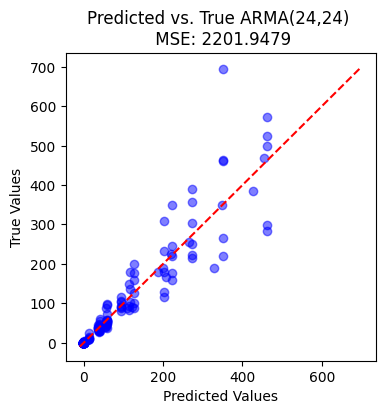

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

# Create a scatter plot
plt.figure(figsize=(4, 4))
plt.scatter(predictions3, test1['orders'], color='blue', alpha=0.5)
plt.plot([-10, 700], [-10, 700], color='red', linestyle='--')  # Diagonal line representing perfect predictions

# # calculate root mean squared error
mse_sarima_te = mean_squared_error(predictions3, test1['orders'])
r2_sarima_te = r2_score(predictions3, test1['orders'])

# Add labels and title
plt.title('Predicted vs. True ARMA(24,24) \n MSE: %.4f' % (mse_sarima_te))

plt.xlabel('Predicted Values')
plt.ylabel('True Values')

# Set axis limits for better visualization
plt.show()